# Model Testing & Benchmarking Notebook

This notebook performs the following tasks:
1. **Reconstructs the Model**: Defines the classes exactly as they were during training.
2. **Loads Resources**: Loads the vocab and embedding matrix.
3. **Top-5 Accuracy Evaluation**: Calculates validation accuracy including Top-5 probability.
4. **Speed Benchmark**: measures inference latency (ms) and throughput (samples/sec) on CPU vs GPU across different batch sizes.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pytorch_lightning as pl
import numpy as np
import json
import time
import os

# ==========================================
# 0. Configuration
# ==========================================
class TestConfig:
    # Paths (Must match your training setup)
    EMBED_PATH = 'embedding_matrix.npz'
    W2I_PATH = 'word2id.json'
    I2W_PATH = 'id2word.json'
    DATA_PATH = 'processed_reddit.txt'
    
    # POINT THIS TO YOUR SAVED CHECKPOINT
    CHECKPOINT_PATH = '../lightning_logs/version_2/checkpoints/epoch=11-step=67968.ckpt' 
    
    # Model Hyperparameters (Must match training)
    HIDDEN_DIM = 512
    NUM_LAYERS = 3
    DROPOUT = 0.3
    
    # Testing Params
    BATCH_SIZES_TO_TEST = [1, 16, 64, 256]
    MAX_LEN = 30

In [2]:
# ==========================================
# 1. Class Definitions (Must match Training)
# ==========================================
# We redefine these here to ensure we can load the checkpoint 
# without needing to import the original file as a module.

class SelfAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(SelfAttention, self).__init__()
        self.hidden_dim = hidden_dim
        self.projection = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, encoder_outputs):
        energy = self.projection(encoder_outputs)
        weights = F.softmax(energy.squeeze(-1), dim=1)
        context = torch.bmm(weights.unsqueeze(1), encoder_outputs)
        return context.squeeze(1), weights

class CompletionModel(pl.LightningModule):
    def __init__(self, embedding_tensor, hidden_dim, num_layers, dropout, lr=1e-3):
        super().__init__()
        self.save_hyperparameters(ignore=['embedding_tensor'])
        
        self.vocab_size = embedding_tensor.size(0)
        self.embed_dim = embedding_tensor.size(1)
        
        # Look up PAD_ID handling (assuming 0 based on previous context)
        self.embedding = nn.Embedding.from_pretrained(
            embedding_tensor, freeze=False, padding_idx=0
        )
        
        self.gru = nn.GRU(
            input_size=self.embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.attention = nn.Linear(hidden_dim, hidden_dim) 
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.fc = nn.Linear(hidden_dim, self.vocab_size)
        self.criterion = nn.CrossEntropyLoss(ignore_index=-100)

    def forward(self, x):
        embedded = self.embedding(x)
        gru_out, _ = self.gru(embedded)
        attn_out = torch.tanh(self.attention(gru_out))
        out = self.layer_norm(gru_out + attn_out)
        logits = self.fc(out)
        return logits

# Dataset Utils
class DailyDialogDataset(Dataset):
    def __init__(self, file_path, w2i, max_len=50):
        self.sentences = []
        self.w2i = w2i
        self.max_len = max_len
        if os.path.exists(file_path):
            with open(file_path, 'r', encoding='utf-8') as f:
                for line in f:
                    line = line.strip()
                    if line: self.sentences.append(line)
        else:
            print("Warning: Data file not found. Benchmarking will use dummy data.")

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        text = self.sentences[idx]
        words = text.split()
        # Default tokens (Assuming mapping is provided externally)
        token_ids = [self.w2i.get(w, self.w2i.get('<UNK>', 1)) for w in words]
        token_ids.append(self.w2i.get('<EOS>', 2))
        if len(token_ids) > self.max_len:
            token_ids = token_ids[:self.max_len]
        return torch.tensor(token_ids, dtype=torch.long)

def completion_collate_fn(batch):
    # Assuming PAD_ID is 0 based on previous notebook
    PAD_ID = 0 
    UNK_ID = 1
    padded_batch = pad_sequence(batch, batch_first=True, padding_value=PAD_ID)
    inputs = padded_batch[:, :-1]
    targets = padded_batch[:, 1:]
    loss_targets = targets.clone()
    loss_targets[loss_targets == UNK_ID] = -100
    loss_targets[loss_targets == PAD_ID] = -100
    return inputs, loss_targets

In [3]:
# ==========================================
# 2. Load Resources & Model
# ==========================================

print("Loading mappings and embeddings...")

if os.path.exists(TestConfig.W2I_PATH):
    with open(TestConfig.W2I_PATH, 'r') as f:
        word2id = {k: int(v) for k, v in json.load(f).items()}
    with open(TestConfig.I2W_PATH, 'r') as f:
        id2word = {int(k): v for k, v in json.load(f).items()}
else:
    # Mock for demonstration if files missing
    print("Warning: Mapping files not found. Creating dummy mappings.")
    word2id = {'<PAD>': 0, '<UNK>': 1, '<EOS>': 2, 'hello': 3, 'world': 4}
    id2word = {v: k for k, v in word2id.items()}

if os.path.exists(TestConfig.EMBED_PATH):
    loaded_embeds = np.load(TestConfig.EMBED_PATH)
    embedding_matrix = loaded_embeds['arr_0'] if 'arr_0' in loaded_embeds else loaded_embeds[list(loaded_embeds.keys())[0]]
    embedding_tensor = torch.from_numpy(embedding_matrix).float()
else:
    print("Warning: Embedding file not found. Creating random embeddings.")
    embedding_tensor = torch.randn(len(word2id), 300) # Assuming 300 dim

print("Initializing Model...")
model = CompletionModel(
    embedding_tensor=embedding_tensor,
    hidden_dim=TestConfig.HIDDEN_DIM,
    num_layers=TestConfig.NUM_LAYERS,
    dropout=TestConfig.DROPOUT,
    lr=0.001
)

# Load weights if checkpoint exists
if os.path.exists(TestConfig.CHECKPOINT_PATH):
    print(f"Loading checkpoint from {TestConfig.CHECKPOINT_PATH}")
    checkpoint = torch.load(TestConfig.CHECKPOINT_PATH, map_location='cpu')
    # We use load_state_dict strictly or via wrapper
    model.load_state_dict(checkpoint['state_dict'])
else:
    print("!!! NO CHECKPOINT FOUND. Using random weights for benchmarking. !!!")
    
model.eval()

Loading mappings and embeddings...
Initializing Model...
Loading checkpoint from ../lightning_logs/version_2/checkpoints/epoch=11-step=67968.ckpt


CompletionModel(
  (embedding): Embedding(10003, 300, padding_idx=0)
  (gru): GRU(300, 512, num_layers=3, batch_first=True, dropout=0.3)
  (attention): Linear(in_features=512, out_features=512, bias=True)
  (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=512, out_features=10003, bias=True)
  (criterion): CrossEntropyLoss()
)

In [4]:
# ==========================================
# 3. Accuracy Evaluation (Top-1 & Top-5)
# ==========================================

def evaluate_accuracy(model, dataloader, device):
    model.to(device)
    model.eval()
    
    total_valid_tokens = 0
    correct_top1 = 0
    correct_top5 = 0
    
    print(f"Evaluating on {device}...")
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            logits = model(inputs) # [Batch, Seq, Vocab]
            
            # Flatten for easier comparison
            # logits_flat: [Batch*Seq, Vocab]
            logits_flat = logits.view(-1, logits.size(-1))
            targets_flat = targets.view(-1)
            
            # Create mask for valid targets (ignore -100)
            mask = targets_flat != -100
            
            # Filter valid logits and targets
            valid_logits = logits_flat[mask]
            valid_targets = targets_flat[mask]
            
            if len(valid_targets) == 0:
                continue
                
            total_valid_tokens += len(valid_targets)
            
            # --- Top-1 Accuracy ---
            preds = torch.argmax(valid_logits, dim=1)
            correct_top1 += (preds == valid_targets).sum().item()
            
            # --- Top-5 Accuracy ---
            # Get top 5 indices: [N_valid, 5]
            _, top5_indices = valid_logits.topk(5, dim=1)
            
            # Check if target is in top 5
            # expand target to [N_valid, 1] for broadcasting
            target_expanded = valid_targets.view(-1, 1)
            
            # matches: [N_valid, 5] boolean
            matches = (top5_indices == target_expanded)
            
            # Sum occurrences where any of the top 5 matched
            correct_top5 += matches.sum().item()
            
            if batch_idx % 50 == 0 and batch_idx > 0:
                print(f"Processed {batch_idx} batches...")

    acc_top1 = correct_top1 / total_valid_tokens if total_valid_tokens > 0 else 0
    acc_top5 = correct_top5 / total_valid_tokens if total_valid_tokens > 0 else 0
    
    return acc_top1, acc_top5

# Create Dataset/Loader for Evaluation
full_dataset = DailyDialogDataset(TestConfig.DATA_PATH, word2id, max_len=TestConfig.MAX_LEN)
# Use a subset for quick testing if dataset is huge
eval_size = min(len(full_dataset), 2000)
eval_dataset, _ = torch.utils.data.random_split(full_dataset, [eval_size, len(full_dataset)-eval_size])

eval_loader = DataLoader(eval_dataset, batch_size=128, collate_fn=completion_collate_fn, shuffle=False)

if len(eval_dataset) > 0:
    device_eval = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    top1, top5 = evaluate_accuracy(model, eval_loader, device_eval)
    print("\n" + "="*30)
    print(f"Results on {eval_size} samples:")
    print(f"Top-1 Accuracy: {top1:.4f}")
    print(f"Top-5 Accuracy: {top5:.4f}")
    print("="*30 + "\n")
else:
    print("Skipping accuracy test (No data found).")

Evaluating on cuda...

Results on 2000 samples:
Top-1 Accuracy: 0.2825
Top-5 Accuracy: 0.5386



In [5]:
# ==========================================
# 4. Speed Benchmarking (CPU vs GPU)
# ==========================================

def benchmark_inference(model, batch_size, device_name, seq_len=20, num_batches=20):
    device = torch.device(device_name)
    model.to(device)
    model.eval()
    
    # Generate dummy data for consistent benchmarking
    # Inputs: [Batch, Seq]
    dummy_input = torch.randint(0, model.vocab_size, (batch_size, seq_len)).to(device)
    
    # Warm-up (ensure CUDA kernels are initialized)
    print(f"[{device_name.upper()}] Warming up...")
    with torch.no_grad():
        for _ in range(5):
            _ = model(dummy_input)
    
    if device_name == 'cuda':
        torch.cuda.synchronize()
        
    print(f"[{device_name.upper()}] Benchmarking Batch Size {batch_size}...")
    
    start_time = time.time()
    
    with torch.no_grad():
        for _ in range(num_batches):
            _ = model(dummy_input)
            # Synchronize if GPU to get accurate timing for this step (optional, usually done at end)
            
    if device_name == 'cuda':
        torch.cuda.synchronize()
        
    end_time = time.time()
    
    total_time = end_time - start_time
    avg_time_per_batch = total_time / num_batches
    avg_time_per_sample = avg_time_per_batch / batch_size
    throughput = (batch_size * num_batches) / total_time
    
    return {
        "device": device_name,
        "batch_size": batch_size,
        "time_per_batch_ms": avg_time_per_batch * 1000,
        "samples_per_sec": throughput
    }

# Define configurations
devices_to_test = ['cpu']
if torch.cuda.is_available():
    devices_to_test.append('cuda')

batch_sizes = TestConfig.BATCH_SIZES_TO_TEST
results = []

for device in devices_to_test:
    for bs in batch_sizes:
        try:
            res = benchmark_inference(model, bs, device)
            results.append(res)
        except RuntimeError as e:
            print(f"OOM or Error on {device} with batch {bs}: {e}")

# Display Results
print("\n" + "="*60)
print(f"{'Device':<10} | {'Batch':<8} | {'Latency (ms/batch)':<20} | {'Throughput (samp/s)':<20}")
print("-"*60)
for r in results:
    print(f"{r['device']:<10} | {r['batch_size']:<8} | {r['time_per_batch_ms']:<20.2f} | {r['samples_per_sec']:<20.2f}")
print("="*60)

[CPU] Warming up...
[CPU] Benchmarking Batch Size 1...
[CPU] Warming up...
[CPU] Benchmarking Batch Size 16...
[CPU] Warming up...
[CPU] Benchmarking Batch Size 64...
[CPU] Warming up...
[CPU] Benchmarking Batch Size 256...
[CUDA] Warming up...
[CUDA] Benchmarking Batch Size 1...
[CUDA] Warming up...
[CUDA] Benchmarking Batch Size 16...
[CUDA] Warming up...
[CUDA] Benchmarking Batch Size 64...
[CUDA] Warming up...
[CUDA] Benchmarking Batch Size 256...

Device     | Batch    | Latency (ms/batch)   | Throughput (samp/s) 
------------------------------------------------------------
cpu        | 1        | 17.09                | 58.53               
cpu        | 16       | 39.41                | 405.94              
cpu        | 64       | 117.15               | 546.30              
cpu        | 256      | 403.00               | 635.23              
cuda       | 1        | 0.91                 | 1098.03             
cuda       | 16       | 1.57                 | 10160.77            
cuda  

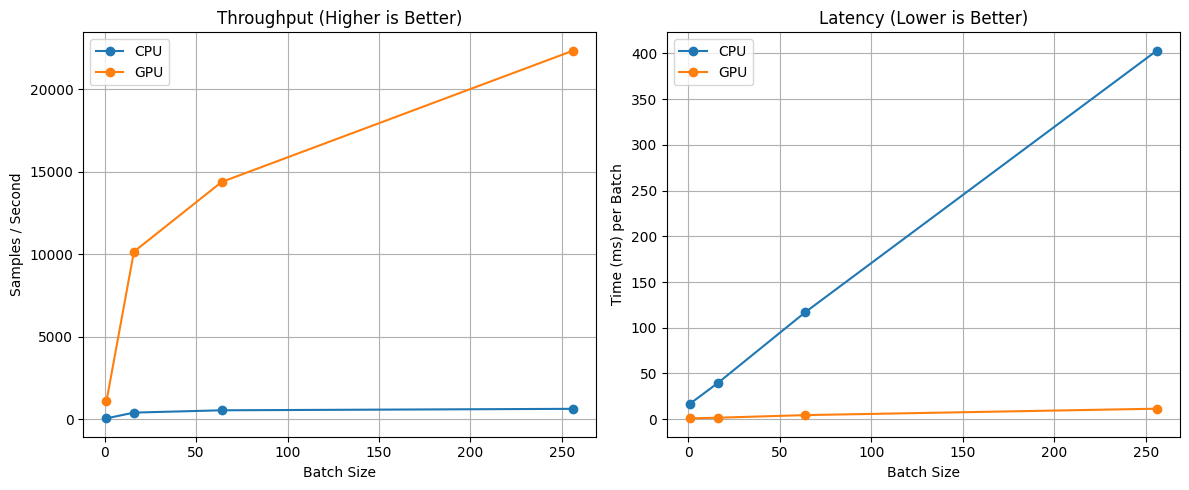

In [6]:
# Optional: Visualize Benchmarks if Matplotlib is installed
try:
    import matplotlib.pyplot as plt
    
    cpu_data = [r for r in results if r['device'] == 'cpu']
    gpu_data = [r for r in results if r['device'] == 'cuda']
    
    plt.figure(figsize=(12, 5))
    
    # Plot Throughput
    plt.subplot(1, 2, 1)
    if cpu_data:
        plt.plot([r['batch_size'] for r in cpu_data], [r['samples_per_sec'] for r in cpu_data], marker='o', label='CPU')
    if gpu_data:
        plt.plot([r['batch_size'] for r in gpu_data], [r['samples_per_sec'] for r in gpu_data], marker='o', label='GPU')
    plt.xlabel('Batch Size')
    plt.ylabel('Samples / Second')
    plt.title('Throughput (Higher is Better)')
    plt.legend()
    plt.grid(True)
    
    # Plot Latency
    plt.subplot(1, 2, 2)
    if cpu_data:
        plt.plot([r['batch_size'] for r in cpu_data], [r['time_per_batch_ms'] for r in cpu_data], marker='o', label='CPU')
    if gpu_data:
        plt.plot([r['batch_size'] for r in gpu_data], [r['time_per_batch_ms'] for r in gpu_data], marker='o', label='GPU')
    plt.xlabel('Batch Size')
    plt.ylabel('Time (ms) per Batch')
    plt.title('Latency (Lower is Better)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

except ImportError:
    print("Matplotlib not found, skipping plots.")